In [1]:
# GPU setup for TensorFlow and PyTorch (if available)
try:
    import tensorflow as tf
    print("TensorFlow version:", tf.__version__)
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"TensorFlow GPUs available: {len(gpus)} physical, {len(logical_gpus)} logical")
        except Exception as e:
            print("Could not set TF GPU memory growth:", e)
    else:
        print("No TensorFlow GPU detected; TF will use CPU.")
except Exception as e:
    print("TensorFlow not available:", e)

# Optional PyTorch device setup if used later
try:
    import torch
    torch_cuda = torch.cuda.is_available()
    device = torch.device('cuda' if torch_cuda else 'cpu')
    print("PyTorch CUDA available:", torch_cuda)
    if torch_cuda:
        print("Using PyTorch device:", torch.cuda.get_device_name(0))
    else:
        print("Using PyTorch device: CPU")
except Exception as e:
    print("PyTorch not available:", e)

2025-12-07 17:49:26.611049: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 17:49:26.961354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-07 17:49:27.997268: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.16.1
TensorFlow GPUs available: 1 physical, 1 logical


2025-12-07 17:49:29.321741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-07 17:49:29.492275: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-07 17:49:29.492306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-07 17:49:29.494880: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-07 17:49:29.494919: I external/local_xla/xla/stream_executor

PyTorch CUDA available: True
Using PyTorch device: NVIDIA GeForce RTX 4070 Laptop GPU


In [2]:
# GPU diagnostics and assertion: must run on GPU
import os, sys
print("Python:", sys.version)

# TensorFlow check
try:
    import tensorflow as tf
    print("TensorFlow:", tf.__version__)
    tf_gpus = tf.config.list_physical_devices('GPU')
    print("TF GPUs:", tf_gpus)
    if tf_gpus:
        # Optional: enable device placement logging for clarity
        os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "1")  # INFO
        try:
            for gpu in tf_gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical = tf.config.list_logical_devices('GPU')
            print(f"TF GPU ready: {len(tf_gpus)} physical, {len(logical)} logical")
        except Exception as e:
            print("Warn: couldn't set TF memory growth:", e)
    else:
        raise RuntimeError("TensorFlow GPU not detected. Install CUDA/cuDNN and correct env.")
except Exception as e:
    raise RuntimeError(f"TensorFlow check failed: {e}")


Python: 3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]
TensorFlow: 2.16.1
TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TF GPU ready: 1 physical, 1 logical


# Fake Image Detection using Error Level Analysis (ELA) and CNN

This notebook implements a Convolutional Neural Network (CNN) to detect fake images by analyzing their compression artifacts using Error Level Analysis (ELA).

### Prerequisite: Dataset Structure
Ensure your dataset is uploaded and structured as follows:
```
dataset/
├── train/
│   ├── real/
│   └── fake/
├── validation/
│   ├── real/
│   └── fake/
└── test/
    ├── real/
    └── fake/
```

In [3]:
# If using Google Colab, uncomment the following lines to mount your drive
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1. Configuration

In [5]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 20
# Update this path to point to your dataset location
DATASET_PATH = './dataset'

# ELA settings
ELA_QUALITY = 90  # try 70-95
ELA_QUALITIES = None  # e.g., [80, 90, 95] to generate multiple versions

## 2. Error Level Analysis (ELA) Function
This function resaves the image at a specific quality level and calculates the difference (error) between the original and the compressed version.

In [6]:
def convert_to_ela_image(path, quality=90):
    temp_filename = "temp_ela.jpg"

    try:
        image = Image.open(path).convert("RGB")
        image.save(temp_filename, "JPEG", quality=quality)

        compressed = Image.open(temp_filename)
        ela_img = ImageChops.difference(image, compressed)

        extrema = ela_img.getextrema()
        max_diff = max([ex[1] for ex in extrema]) or 1
        scale = 255.0 / max_diff

        ela_img = ImageEnhance.Brightness(ela_img).enhance(scale)
        return ela_img.resize(IMAGE_SIZE)

    except Exception as e:
        print(f"[ELA ERROR] {path}: {e}")
        return None

def build_ela_stack(path):
    if ELA_QUALITIES and isinstance(ELA_QUALITIES, (list, tuple)):
        imgs = []
        for q in ELA_QUALITIES:
            img = convert_to_ela_image(path, quality=q)
            if img is not None:
                imgs.append(np.array(img) / 255.0)
        if len(imgs) > 0:
            # stack along channel dimension
            stacked = np.concatenate(imgs, axis=-1)
            # if channels exceed 3, truncate to first 3 to fit current model
            return stacked[..., :3]
    # fallback single quality
    img = convert_to_ela_image(path, quality=ELA_QUALITY)
    return np.array(img) / 255.0 if img is not None else None

## 3. Frequency Domain Analysis (FFT)
The FFT reveals periodic compression artifacts and copy-paste seams that may be subtle in the spatial domain. The cells below compute a log-magnitude spectrum and simple band energy statistics for each image.

In [7]:
def compute_frequency_map(img_path):
    """Return normalized log-magnitude FFT spectrum for the grayscale image."""
    image = Image.open(img_path).convert("L").resize(IMAGE_SIZE)
    spectrum = np.fft.fftshift(np.fft.fft2(image))
    magnitude = 20 * np.log(np.abs(spectrum) + 1e-8)
    normalized = (magnitude - magnitude.min()) / (np.ptp(magnitude) + 1e-8)
    return normalized

def band_energy_stats(freq_map, high_cut=0.6, mid_cut=0.3):
    """Compute average energy in low/mid/high frequency bands using radial masks."""
    h, w = freq_map.shape
    cy, cx = h // 2, w // 2
    y, x = np.ogrid[:h, :w]
    radius = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
    max_r = radius.max()

    low_mask = radius <= mid_cut * max_r
    mid_mask = (radius > mid_cut * max_r) & (radius <= high_cut * max_r)
    high_mask = radius > high_cut * max_r

    return {
        "low": float(freq_map[low_mask].mean()),
        "mid": float(freq_map[mid_mask].mean()),
        "high": float(freq_map[high_mask].mean()),
    }

def visualize_frequency_analysis(img_path):
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
        return

    original = Image.open(img_path).resize(IMAGE_SIZE)
    ela_img = convert_to_ela_image(img_path)
    if ela_img is None:
        print(f"ELA failed for {img_path}")
        return

    freq_map = compute_frequency_map(img_path)
    energy = band_energy_stats(freq_map)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(ela_img)
    axes[1].set_title("ELA")
    axes[1].axis("off")

    axes[2].imshow(freq_map, cmap="magma")
    axes[2].set_title(
        f"Frequency magnitude\n(low/mid/high): {energy['low']:.3f} / {energy['mid']:.3f} / {energy['high']:.3f}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    print(
        f"Energy stats for {img_path} -> low: {energy['low']:.3f}, mid: {energy['mid']:.3f}, high: {energy['high']:.3f}")

## 4. Data Loading Helper

In [8]:
def load_split(split_path):
    X = []
    Y = []

    classes = ["real", "fake"]

    for label, class_name in enumerate(classes):
        folder = os.path.join(split_path, class_name)

        if not os.path.isdir(folder):
            print(f"[WARNING] Missing folder: {folder}")
            continue

        print(f"Loading '{class_name}' images from {split_path} ...")

        for filename in os.listdir(folder):
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            img_path = os.path.join(folder, filename)
            ela_img = convert_to_ela_image(img_path)

            if ela_img:
                X.append(np.array(ela_img) / 255.0)
                Y.append(label)

    return np.array(X), to_categorical(Y, 2)


def load_freq_split(split_path):
    X = []
    Y = []
    classes = ["real", "fake"]

    for label, class_name in enumerate(classes):
        folder = os.path.join(split_path, class_name)
        if not os.path.isdir(folder):
            print(f"[WARNING] Missing folder: {folder}")
            continue

        print(f"Loading '{class_name}' frequency images from {split_path} ...")
        for filename in os.listdir(folder):
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            img_path = os.path.join(folder, filename)
            freq_map = compute_frequency_map(img_path)
            if freq_map is not None:
                X.append(freq_map[..., np.newaxis])  # add channel dim
                Y.append(label)

    return np.array(X), to_categorical(Y, 2)

## 5. Load Datasets

In [9]:
print("\n===== LOADING TRAIN DATA =====")
x_train, y_train = load_split(os.path.join(DATASET_PATH, "train"))
print("\n===== LOADING TRAIN (FREQ) DATA =====")
x_train_freq, y_train_freq = load_freq_split(os.path.join(DATASET_PATH, "train"))

print("\n===== LOADING VALIDATION DATA =====")
x_val, y_val = load_split(os.path.join(DATASET_PATH, "validation"))
print("\n===== LOADING VALIDATION (FREQ) DATA =====")
x_val_freq, y_val_freq = load_freq_split(os.path.join(DATASET_PATH, "validation"))

print("\n===== LOADING TEST DATA =====")
x_test, y_test = load_split(os.path.join(DATASET_PATH, "test"))
print("\n===== LOADING TEST (FREQ) DATA =====")
x_test_freq, y_test_freq = load_freq_split(os.path.join(DATASET_PATH, "test"))

print("\nDataset Summary:")
print(f"Train: {len(x_train)} images | Freq: {len(x_train_freq)} images")
print(f"Validation: {len(x_val)} images | Freq: {len(x_val_freq)} images")
print(f"Test: {len(x_test)} images | Freq: {len(x_test_freq)} images")


===== LOADING TRAIN DATA =====
Loading 'real' images from ./dataset/train ...
Loading 'fake' images from ./dataset/train ...

===== LOADING TRAIN (FREQ) DATA =====
Loading 'real' frequency images from ./dataset/train ...
Loading 'fake' frequency images from ./dataset/train ...

===== LOADING VALIDATION DATA =====
Loading 'real' images from ./dataset/validation ...
Loading 'fake' images from ./dataset/validation ...

===== LOADING VALIDATION (FREQ) DATA =====
Loading 'real' frequency images from ./dataset/validation ...
Loading 'fake' frequency images from ./dataset/validation ...

===== LOADING TEST DATA =====
Loading 'real' images from ./dataset/test ...
Loading 'fake' images from ./dataset/test ...

===== LOADING TEST (FREQ) DATA =====
Loading 'real' frequency images from ./dataset/test ...
Loading 'fake' frequency images from ./dataset/test ...

Dataset Summary:
Train: 1523 images | Freq: 1523 images
Validation: 1319 images | Freq: 1319 images
Test: 1387 images | Freq: 1387 images


## 6. Build CNN Model

In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')   # real vs fake
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
 )

freq_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

freq_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
 )

print("ELA model:")
model.summary()
print("\nFrequency model:")
freq_model.summary()

/home/nisar/ml-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ELA model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,665,538 (25.43 MB)

 Trainable params: 6,664,834 (25.42 MB)

 Non-trainable params: 704 (2.75 KB)


Frequency model:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,664,962 (25.42 MB)

 Trainable params: 6,664,258 (25.42 MB)

 Non-trainable params: 704 (2.75 KB)

## 7. Training

In [11]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_ela_model.h5', monitor='val_accuracy', save_best_only=True)
]

callbacks_freq = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_freq_model.h5', monitor='val_accuracy', save_best_only=True)
]

if len(x_train) > 0:
    print("\n===== STARTING TRAINING (ELA) =====")
    history = model.fit(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=1
)
else:
    print("No ELA training data found. Please check your DATASET_PATH.")

if len(x_train_freq) > 0:
    print("\n===== STARTING TRAINING (FREQ) =====")
    history_freq = freq_model.fit(
        x_train_freq, y_train_freq,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_val_freq, y_val_freq),
        callbacks=callbacks_freq,
        verbose=1
)
else:
    print("No frequency training data found. Please check your DATASET_PATH.")


===== STARTING TRAINING (ELA) =====
Epoch 1/20


I0000 00:00:1765151827.933478   48124 service.cc:145] XLA service 0x741768005ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765151827.934138   48124 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-12-07 17:57:08.034501: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-07 17:57:08.287897: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 3/48 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.4462 - loss: 14.1333

I0000 00:00:1765151834.535467   48124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5757 - loss: 8.3680

48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 321ms/step - accuracy: 0.6277 - loss: 5.6001 - val_accuracy: 0.4147 - val_loss: 7.8598 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.6868 - loss: 1.2576 - val_accuracy: 0.4147 - val_loss: 3.3167 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.7308 - loss: 0.5842 - val_accuracy: 0.4147 - val_loss: 5.4730 - learning_rate: 0.0010
Epoch 4/20
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7637 - loss: 0.5038

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.7715 - loss: 0.4953 - val_accuracy: 0.4382 - val_loss: 0.7803 - learning_rate: 0.0010
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8122 - loss: 0.4393 - val_accuracy: 0.4147 - val_loss: 1.1126 - learning_rate: 0.0010
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8201 - loss: 0.4152 - val_accuracy: 0.4147 - val_loss: 2.3669 - learning_rate: 0.0010
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.8477 - loss: 0.3468 - val_accuracy: 0.4147 - val_loss: 2.9195 - learning_rate: 0.0010
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8733 - loss: 0.3191 - val_accuracy: 0.4200 - val_loss: 2.8492 - learning_rate: 0.0010
Epoch 9/20
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9100 - loss: 0.2272

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9054 - loss: 0.2286 - val_accuracy: 0.4989 - val_loss: 1.8610 - learning_rate: 0.0010
Epoch 10/20
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9302 - loss: 0.1737

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9383 - loss: 0.1584 - val_accuracy: 0.5072 - val_loss: 2.4565 - learning_rate: 5.0000e-04
Epoch 11/20
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9497 - loss: 0.1195

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9560 - loss: 0.1137 - val_accuracy: 0.6012 - val_loss: 2.0408 - learning_rate: 5.0000e-04
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9645 - loss: 0.0982 - val_accuracy: 0.5709 - val_loss: 2.8455 - learning_rate: 5.0000e-04
Epoch 13/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9666 - loss: 0.0831

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9639 - loss: 0.0897 - val_accuracy: 0.7801 - val_loss: 0.9167 - learning_rate: 5.0000e-04
Epoch 14/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9685 - loss: 0.0722 - val_accuracy: 0.7703 - val_loss: 0.7893 - learning_rate: 5.0000e-04
Epoch 15/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9596 - loss: 0.0801

48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9678 - loss: 0.0696 - val_accuracy: 0.8347 - val_loss: 0.6000 - learning_rate: 2.5000e-04
Epoch 16/20
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9867 - loss: 0.0528

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9856 - loss: 0.0513 - val_accuracy: 0.8567 - val_loss: 0.5681 - learning_rate: 2.5000e-04
Epoch 17/20
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9834 - loss: 0.0461

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9829 - loss: 0.0487 - val_accuracy: 0.8719 - val_loss: 0.5005 - learning_rate: 2.5000e-04
Epoch 18/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9842 - loss: 0.0397 - val_accuracy: 0.8575 - val_loss: 0.5720 - learning_rate: 2.5000e-04
Epoch 19/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9816 - loss: 0.0396 - val_accuracy: 0.8560 - val_loss: 0.5736 - learning_rate: 2.5000e-04
Epoch 20/20
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9872 - loss: 0.0302

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9869 - loss: 0.0312 - val_accuracy: 0.8802 - val_loss: 0.5115 - learning_rate: 2.5000e-04

===== STARTING TRAINING (FREQ) =====
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5623 - loss: 7.8128

48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - accuracy: 0.6008 - loss: 4.4165 - val_accuracy: 0.5853 - val_loss: 4.4038 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6717 - loss: 0.8618 - val_accuracy: 0.5853 - val_loss: 14.5263 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7019 - loss: 0.6775 - val_accuracy: 0.5853 - val_loss: 22.8941 - learning_rate: 0.0010
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6770 - loss: 0.7432 - val_accuracy: 0.5853 - val_loss: 26.4650 - learning_rate: 0.0010
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6980 - loss: 0.7798 - val_accuracy: 0.5853 - val_loss: 24.7551 - learning_rate: 0.0010
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6888 - loss: 0.7727 - val_accuracy: 0.5853 - val_loss: 48.3863 - learning_rate: 0.0010
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7104 - loss: 0.5757 - val_accurac

## 8. Performance Visualization

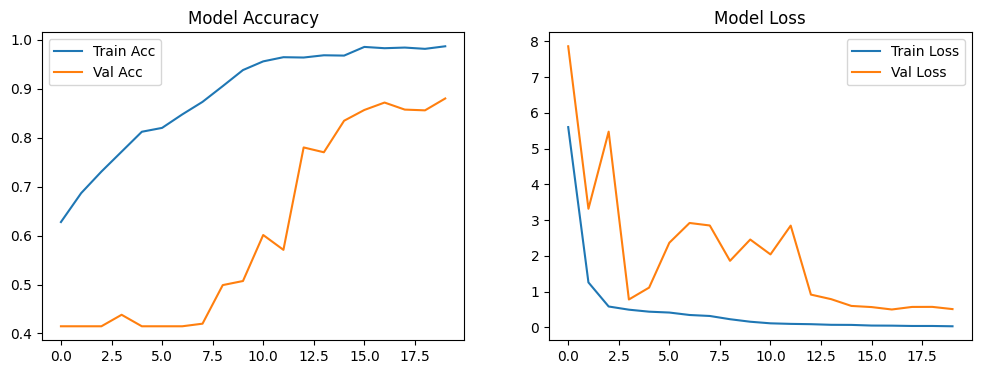

In [12]:
if 'history' in locals():
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title("Model Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Model Loss")
    plt.legend()

    plt.show()

## 9. Evaluation

In [13]:
if len(x_test) > 0:
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f"\n===== TEST ACCURACY (ELA): {test_acc * 100:.1f}% =====")
else:
    print("No ELA test data available.")

if len(x_test_freq) > 0:
    freq_test_loss, freq_test_acc = freq_model.evaluate(x_test_freq, y_test_freq)
    print(f"===== TEST ACCURACY (FREQ): {freq_test_acc * 100:.1f}% =====")
else:
    print("No frequency test data available.")

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7058 - loss: 3.3317

===== TEST ACCURACY (ELA): 70.6% =====
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5213 - loss: 5.0886
===== TEST ACCURACY (FREQ): 52.1% =====


## 10. Prediction Utility

Randomly selected 4 images from 1387 available test images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


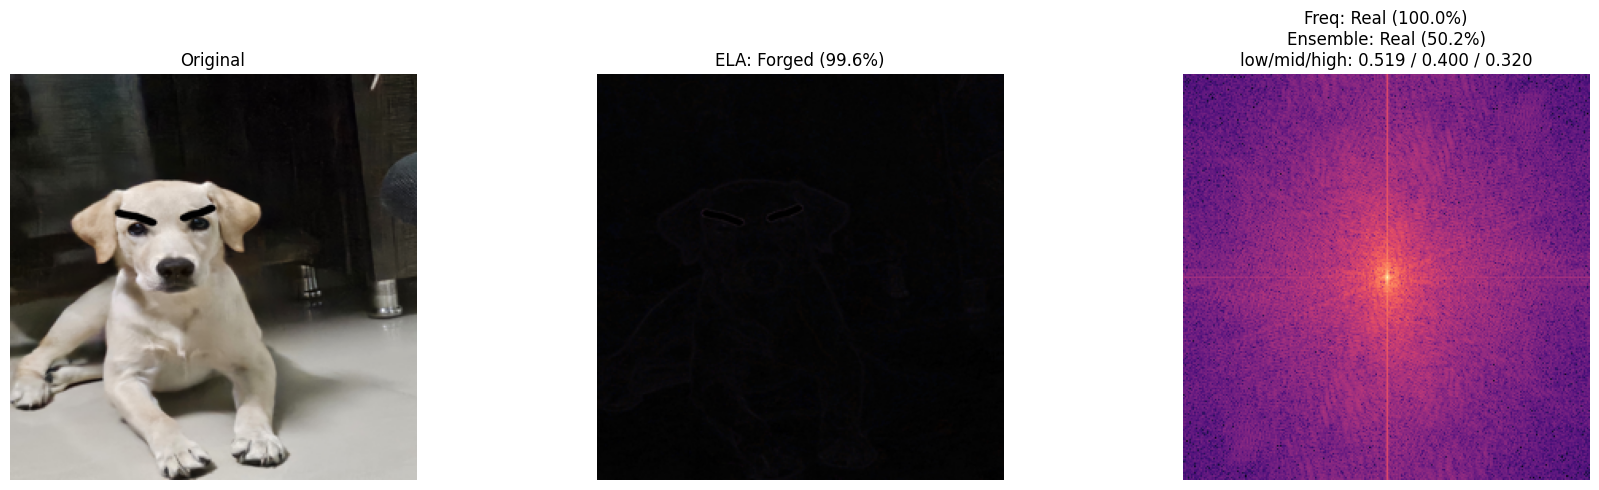

File: ./dataset/test/fake/dog_forged.jpg
ELA: Forged (99.6%) | Freq: Real (100.0%) | Ensemble: Real (50.2%)
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


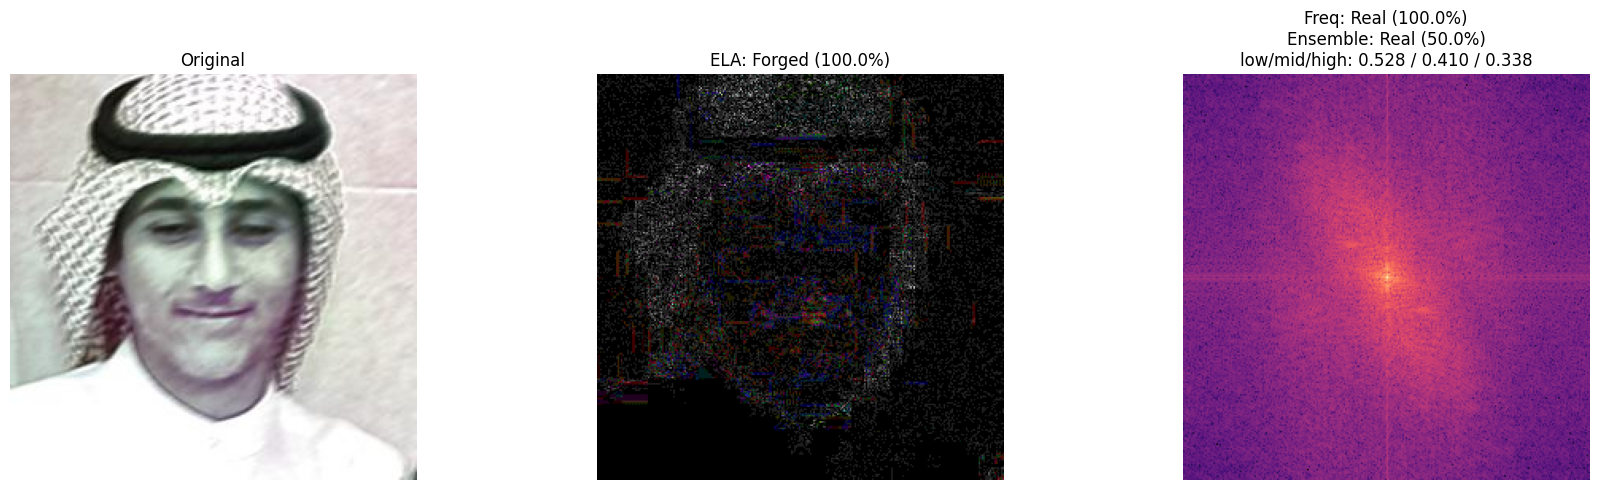

File: ./dataset/test/real/real_4826.jpg
ELA: Forged (100.0%) | Freq: Real (100.0%) | Ensemble: Real (50.0%)
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


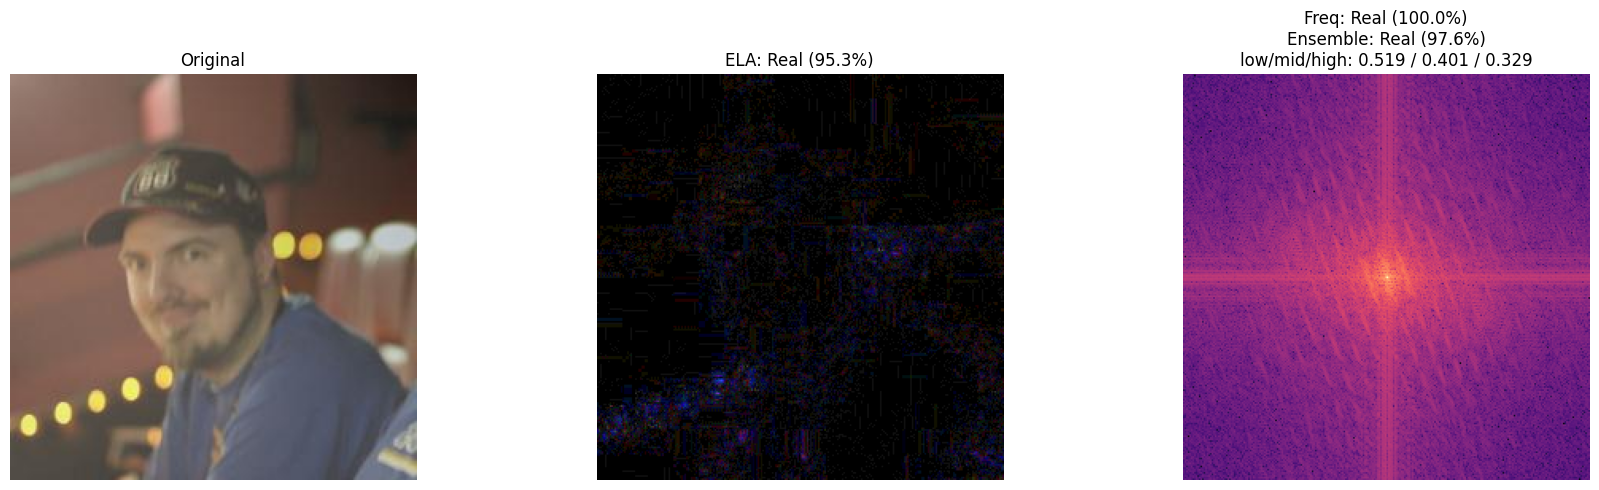

File: ./dataset/test/real/real_51.jpg
ELA: Real (95.3%) | Freq: Real (100.0%) | Ensemble: Real (97.6%)
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


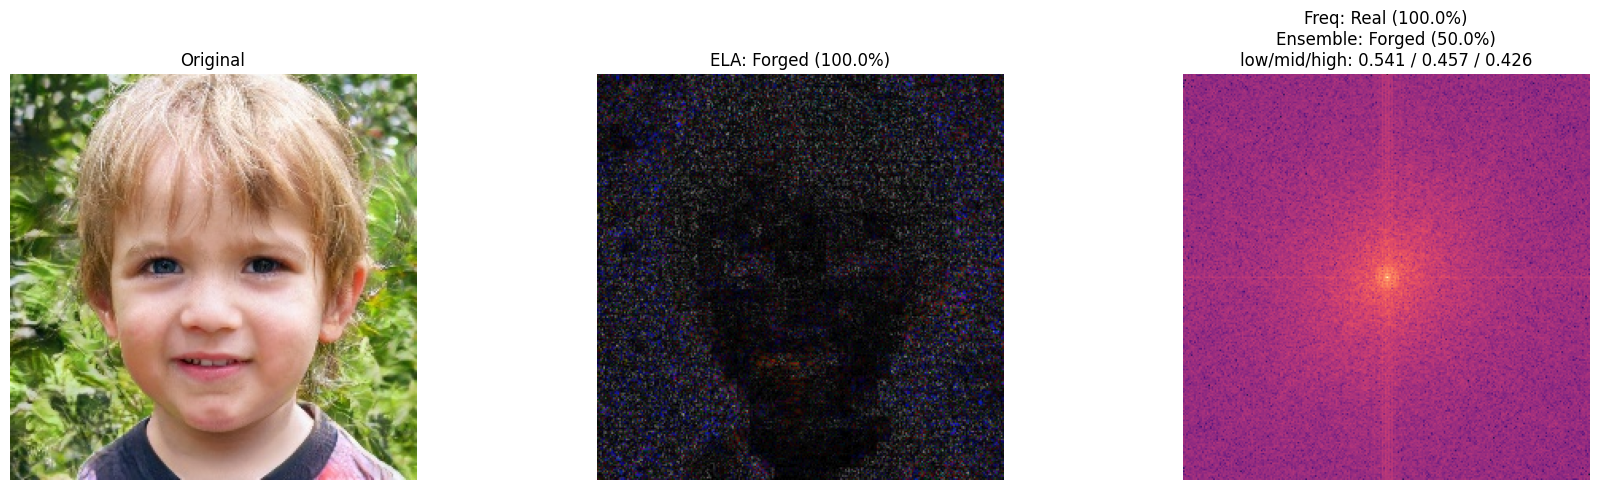

File: ./dataset/test/fake/GPTDLPSX5B.jpg
ELA: Forged (100.0%) | Freq: Real (100.0%) | Ensemble: Forged (50.0%)
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


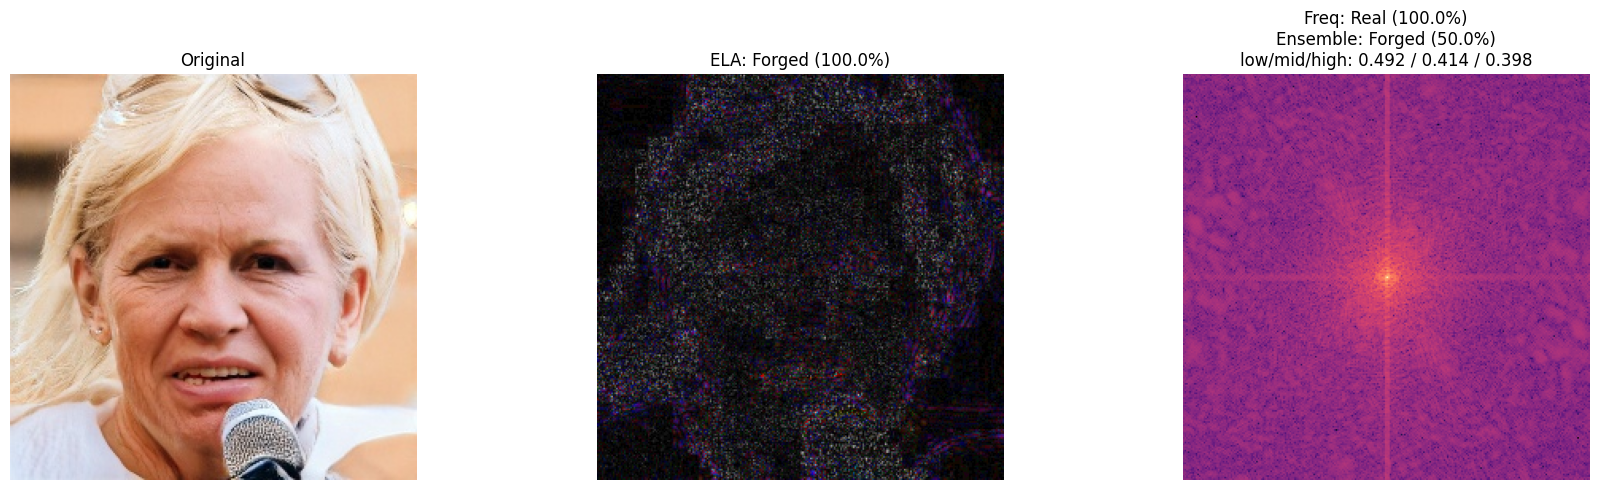

File: ./dataset/test/fake/FNB42NS5V7.jpg
ELA: Forged (100.0%) | Freq: Real (100.0%) | Ensemble: Forged (50.0%)
------------------------------------------------------------


In [14]:
def predict_image(img_path, show=False):
    if not os.path.exists(img_path):
        print(f"Error: File not found -> {img_path}")
        return "Unknown", 0.0, None, None

    original = Image.open(img_path).resize(IMAGE_SIZE)
    ela_img = convert_to_ela_image(img_path, quality=ELA_QUALITY)
    img_array = np.array(ela_img) / 255.0
    img_array = img_array.reshape(1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    pred = model.predict(img_array)
    label = "Forged" if np.argmax(pred) == 1 else "Real"
    confidence = float(np.max(pred))

    if show:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(original)
        plt.title("Original")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(ela_img)
        plt.title(f"ELA\nPrediction: {label} ({confidence * 100:.1f}%)")
        plt.axis("off")
        plt.show()

    return label, confidence, original, ela_img

def predict_image_freq(img_path):
    if not os.path.exists(img_path):
        print(f"Error: File not found -> {img_path}")
        return "Unknown", 0.0, None

    freq_map = compute_frequency_map(img_path)
    freq_tensor = freq_map[np.newaxis, ..., np.newaxis]
    pred = freq_model.predict(freq_tensor)
    label = "Forged" if np.argmax(pred) == 1 else "Real"
    confidence = float(np.max(pred))
    return label, confidence, freq_map

import random

def get_random_images_from_split(split_name="test", num_images=10):
    """Get random images from given split ('test' or 'validation')."""
    all_images = []
    
    for class_name in ("fake", "real"):
        folder = os.path.join(DATASET_PATH, split_name, class_name)
        if os.path.isdir(folder):
            files = [os.path.join(folder, f) for f in os.listdir(folder)
                     if f.lower().endswith((".jpg", ".jpeg", ".png"))]
            all_images.extend(files)
        else:
            print(f"Missing folder: {folder}")
    
    if len(all_images) == 0:
        print(f"No {split_name} images found!")
        return []
    
    num_to_select = min(num_images, len(all_images))
    selected = random.sample(all_images, num_to_select)
    print(f"Randomly selected {num_to_select} images from {len(all_images)} available {split_name} images\n")
    return selected

# Choose source split: 'test' or 'validation'
SOURCE_SPLIT = "test"  # change to "validation" to sample validation images

# Get random images from chosen split
image_files = get_random_images_from_split(split_name=SOURCE_SPLIT, num_images=4)

# Add 1 hardcoded image for comparison (only if it exists in dataset)
hardcoded_image = "./dataset/test/fake/dog_forged.jpg"
if os.path.exists(hardcoded_image):
    image_files = [hardcoded_image] + image_files

# 2. Loop through the list
for file_path in image_files:
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    # Get predictions without separate plots
    ela_label, ela_conf, original, ela_img = predict_image(file_path, show=False)
    freq_label, freq_conf, freq_map = predict_image_freq(file_path)

    # Ensemble prediction (simple average)
    ela_tensor = (np.array(ela_img) / 255.0)[np.newaxis, ...]
    freq_tensor = freq_map[np.newaxis, ..., np.newaxis]
    ela_probs = model.predict(ela_tensor)
    freq_probs = freq_model.predict(freq_tensor)
    ensemble_probs = (ela_probs + freq_probs) / 2.0
    ensemble_label = "Forged" if np.argmax(ensemble_probs) == 1 else "Real"
    ensemble_conf = float(np.max(ensemble_probs))

    if original is None or freq_map is None or ela_img is None:
        continue

    # Compute band energies for display
    energy = band_energy_stats(freq_map)

    # Combined visualization: Original | ELA | Frequency with labels
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(ela_img)
    axes[1].set_title(f"ELA: {ela_label} ({ela_conf * 100:.1f}%)")
    axes[1].axis("off")

    axes[2].imshow(freq_map, cmap="magma")
    axes[2].set_title(
        f"Freq: {freq_label} ({freq_conf * 100:.1f}%)\n"
        f"Ensemble: {ensemble_label} ({ensemble_conf * 100:.1f}%)\n"
        f"low/mid/high: {energy['low']:.3f} / {energy['mid']:.3f} / {energy['high']:.3f}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"File: {file_path}")
    print(
        f"ELA: {ela_label} ({ela_conf * 100:.1f}%) | "
        f"Freq: {freq_label} ({freq_conf * 100:.1f}%) | "
        f"Ensemble: {ensemble_label} ({ensemble_conf * 100:.1f}%)")
    print("-" * 60)